20:03:39 - cmdstanpy - INFO - Chain [1] start processing
20:03:39 - cmdstanpy - INFO - Chain [1] done processing


The predicted amount of passengers for the next 12 months
144    466.54
145    461.01
146    493.47
147    492.12
148    496.44
149    537.53
150    577.09
151    577.52
152    528.96
153    493.80
154    459.95
155    489.33
Name: yhat, dtype: float64


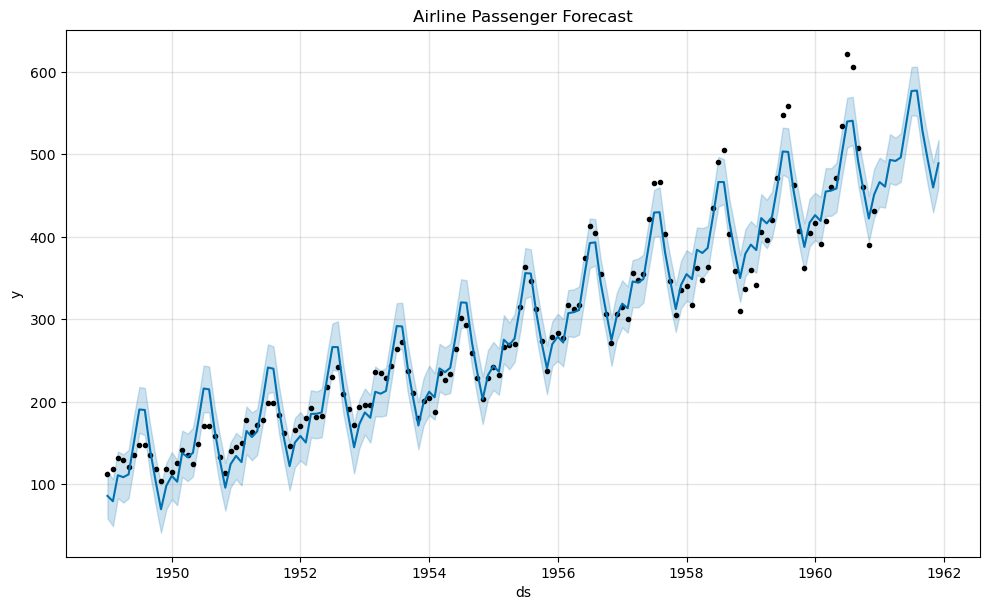

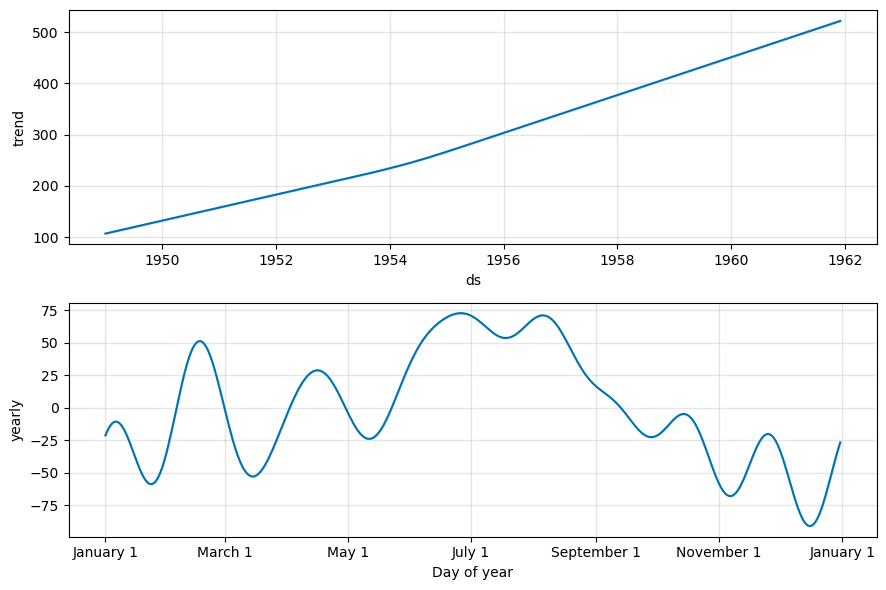

In [1]:
#This predicts using the amount of passengers using the airline
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Sample dataset (Year-Month and # of Passengers)
data = {
    "ds": pd.date_range(start="1949-01-01", periods=144, freq="MS"),
    "y": [
        112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118,
        115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140,
        145, 150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166,
        171, 180, 193, 181, 183, 218, 230, 242, 209, 191, 172, 194,
        196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201,
        204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 229,
        242, 233, 267, 269, 270, 315, 364, 347, 312, 274, 237, 278,
        284, 277, 317, 313, 318, 374, 413, 405, 355, 306, 271, 306,
        315, 301, 356, 348, 355, 422, 465, 467, 404, 347, 305, 336,
        340, 318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337,
        360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405,
        417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432
    ]
}

df = pd.DataFrame(data)


# Initialize model
model = Prophet()
model.fit(df)

# Create future dates (12 months ahead)
future = model.make_future_dataframe(periods=12, freq='MS')

# Make predictions
forecast = model.predict(future)
print("The predicted amount of passengers for the next 12 months")
single_prediction = forecast['yhat'][-12:].round(2)
print(f'{single_prediction}')

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Airline Passenger Forecast")
plt.show()

# Optional: Plot components (trend, yearly seasonality)
fig2 = model.plot_components(forecast)
plt.show()


20:03:41 - cmdstanpy - INFO - Chain [1] start processing
20:03:41 - cmdstanpy - INFO - Chain [1] done processing


The predicted future values are : 
144    440.154596
145    418.816917
146    479.105341
147    479.951273
148    487.240149
149    564.768627
150    641.781618
151    633.285585
152    525.078579
153    452.992092
154    380.896257
155    428.559520
Name: yhat, dtype: float64


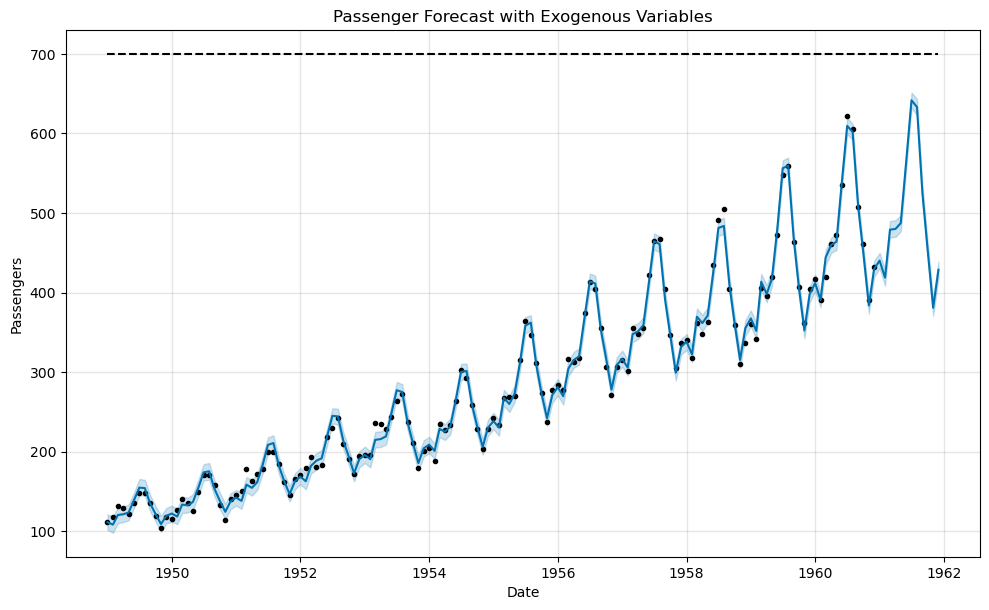

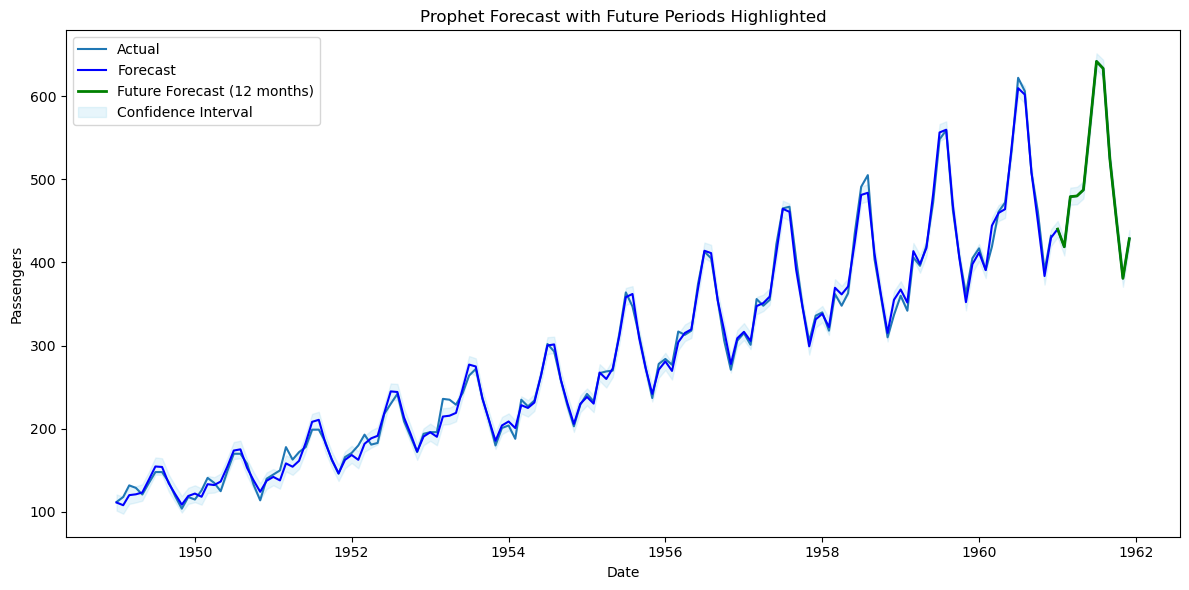

In [2]:
#This adds external variables such as airline_capacity and population to the prediction model
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

# Load the air passengers dataset
from statsmodels.datasets import get_rdataset
data = get_rdataset("AirPassengers").data

# Convert it into Prophet format
df = pd.DataFrame({
    'ds': pd.date_range(start='1949-01-01', periods=len(data), freq='MS'),
    'y': data['value']
})
df['cap'] = 700

# Simulate population growth (linear)
df['population'] = np.linspace(100, 200, len(df))

# Simulate airline capacity (noisy increasing trend)
np.random.seed(42) #This ensures reproducibility of results
df['airline_capacity'] = np.linspace(50, 100, len(df)) + np.random.normal(0, 5, len(df))

m = Prophet(growth='logistic',
    changepoint_prior_scale=0.8,  # allows more flexibility in trend
    yearly_seasonality=True,
    seasonality_mode='multiplicative')

# Add external regressors
m.add_regressor('population')
m.add_regressor('airline_capacity')

# Fit the model
m.fit(df)

# Create the future dataframe (with extra 12 months)
future = m.make_future_dataframe(periods=12, freq='MS')
future['cap'] = 700

# Extend population
# First, create future values
future_population = np.linspace(200, 220, len(future) - len(df))

# Combine past and future
future['population'] = pd.concat([
    df['population'],
    pd.Series(future_population, index=future.index[len(df):])
], ignore_index=False).values

# Extend airline_capacity
future_airline_capacity = (
    np.linspace(100, 110, len(future) - len(df)) +
    np.random.normal(0, 5, len(future) - len(df))
)

future['airline_capacity'] = pd.concat([
    df['airline_capacity'],
    pd.Series(future_airline_capacity, index=future.index[len(df):])
], ignore_index=False).values

forecast = m.predict(future)
multiple_prediction = forecast['yhat'][-12:]
print("The predicted future values are : ")
print(multiple_prediction)

# Plot
fig = m.plot(forecast)
plt.title("Passenger Forecast with Exogenous Variables")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()

######################################################################

# Plot the forecast
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['ds'], df['y'], label='Actual')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')

# Highlight the last 12 predicted values in green
ax.plot(forecast['ds'][-12:], forecast['yhat'][-12:], label='Future Forecast (12 months)', color='green', linewidth=2)

# Optional: confidence intervals
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                color='skyblue', alpha=0.2, label='Confidence Interval')

ax.set_title('Prophet Forecast with Future Periods Highlighted')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.legend()
plt.tight_layout()
plt.show()


144   -26.385404
145   -42.193083
146   -14.364659
147   -12.168727
148    -9.199851
149    27.238627
150    64.691618
151    55.765585
152    -3.881421
153   -40.807908
154   -79.053743
155   -60.770480
Name: yhat, dtype: float64


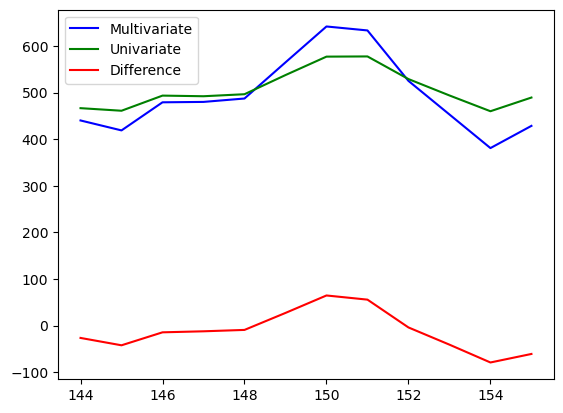

In [3]:
#single_prediction
#multiple_prediction
difference = multiple_prediction - single_prediction
print(difference)
plt.plot(multiple_prediction, color='blue', label='Multivariate')
plt.plot(single_prediction, color='green', label='Univariate')
plt.plot(difference, color='red', label='Difference')
plt.legend()
plt.show()